# Basics of Time Series Analysis
This notebook demonstrates some basic analysis & visualization of time series starting from a pandas dataframe object.

GEE v0.1.286
Monthly Means: 216


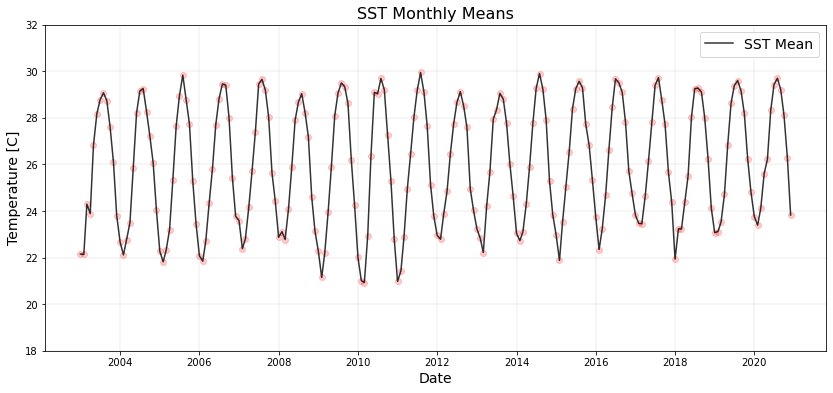

In [1]:
# get GEE data to work with 
import ee
import geemap
import pandas as pd
ee.Initialize()
print(f"GEE v{ee.__version__}")

## Florida MODIS L3 data (uploaded from imars server)
sst = ee.ImageCollection('projects/imars-3d-wetlands/MODIS_L3/FL_SST4') ## SST

band = 'b1' #Type same band in Line 149
renameBand = 'SST'
collection = sst
start_date = '2003-01-01'
end_date = '2020-12-31'

# Establish lists with months and years of selected time range above.
months = ee.List.sequence(1, 12)
years = ee.List.sequence(2003, 2020)

## lat/lon limits
region = ee.Geometry.Polygon([[[-86.25, 22.75], [-78.65, 22.75], [-78.65, 31.15], [-86.25, 31.15], [-86.25, 22.75]]])

## Visualization parameters
palette = ['030d81','0519ff','05e8ff','11ff01','fbff01','ff9901','ff0000','ad0000']
viz = {'min':16,'max':28,'palette':palette}

## Filter collection
filtered = collection.filterDate(ee.Date(start_date), ee.Date(end_date)).select(band)

## Get monthly menas in the defined time range
byMonthYear = ee.ImageCollection.fromImages(
    years.map(
        lambda y: months.map(
            lambda m: filtered\
                .filter(ee.Filter.calendarRange(y, y, 'year'))\
                .filter(ee.Filter.calendarRange(m, m, 'month'))\
                .reduce(ee.Reducer.mean())\
                .set('month', m).set('year', y)
        )
    ).flatten()
)
print('Monthly Means:',byMonthYear.size().getInfo())

# initialize our map
Map = geemap.Map()
Map.centerObject(region, 6)
Map.addLayer(byMonthYear.first(), viz, "Florida")
Map.addLayerControl()

## Function to get mean values
def getStats(img):
    ## Select and rename bands.
    #image = ee.Image(img).select(band+'_mean').rename(renameBand)
    image = ee.Image(img).rename(renameBand)
    ## Create and combine reducers of mean and std.
    reducers = ee.Reducer.mean().combine(
        reducer2= ee.Reducer.stdDev(),
        sharedInputs= True)
    ## Apply reducers to the image.
    stats = image.reduceRegion(
        reducer= reducers,
        geometry= region,
        #bestEffort= True,
        scale= 1000,
        maxPixels= 1e9
    )
    
    ## Create feature variable to allocate data.
    feature = ee.Feature(None)
    ## Set properties of interest.
    properties = ['system:index','month','year',renameBand+'_mean',renameBand+'_stdDev']
    ## Apply the stats on every image and collect the output.
    imageStats = image.setMulti(stats)
    ## return feature with the selected properties.
    return ee.Feature(feature).copyProperties(imageStats, properties)

stats = byMonthYear.map(getStats)

year = pd.DataFrame(stats.aggregate_array('year').getInfo(), columns=['Year'])
month = pd.DataFrame(stats.aggregate_array('month').getInfo(), columns=['Month'])
mean = pd.DataFrame(stats.aggregate_array(renameBand+'_mean').getInfo(), columns=['Mean'])
std = pd.DataFrame(stats.aggregate_array(renameBand+'_stdDev').getInfo(), columns=['StdDev'])

## Concat dataframes
df = pd.concat([year, month, mean, std], axis=1)

## Insert new column with date values
df.insert(0,'Date','')
df['Date'] = df[["Year", "Month"]].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])

import matplotlib.pyplot as plt

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(df['Date'], df['Mean'],c='red',alpha=0.2)
ax.plot(df['Date'], df['Mean'],c='black',alpha=0.8,label=renameBand+' Mean')

# Add some parameters.
ax.set_title(renameBand+' Monthly Means', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(18, 32)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2003-01-01 to 2020-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    216 non-null    datetime64[ns]
 1   Year    216 non-null    int64         
 2   Month   216 non-null    int64         
 3   Mean    216 non-null    float64       
 4   StdDev  216 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 10.1 KB
None
                 Date  Year  Month       Mean    StdDev
Date                                                   
2003-01-01 2003-01-01  2003      1  22.150675  3.488177
2003-02-01 2003-02-01  2003      2  22.137196  3.599461
2003-03-01 2003-03-01  2003      3  24.294582  2.470235
2003-04-01 2003-04-01  2003      4  23.891055  2.102387
2003-05-01 2003-05-01  2003      5  26.836783  0.870850


<AxesSubplot:xlabel='Date'>

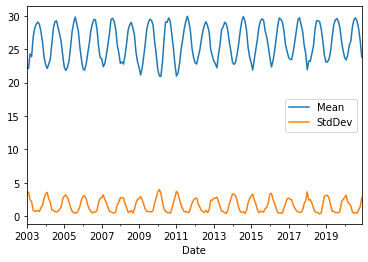

In [8]:
# === prep the dataframe 

print(df.info())

print(df.head())
df.set_index("Date", inplace=True)
df_simplified = df.drop(['Year', 'Month'], axis=1)
df_simplified.plot()  # pandas.DataFrame.plot()


done


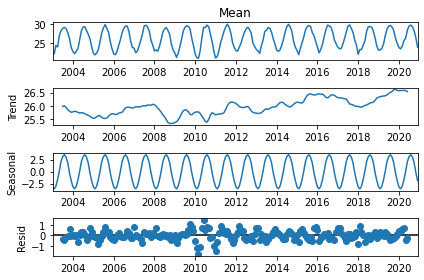

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# In seasonal_decompose we have to set the model. 
# We can either set the model to be Additive or Multiplicative. 
# A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time.
# IE: linear. 
# If yes, then we will select the Additive model.
# Otherwise (the trend and seasonal variation increase or decrease over time) use the Multiplicative model.
result = seasonal_decompose(df_simplified['Mean'], model='additive', period=12)
result.plot()

# result = seasonal_decompose(df_simplified['StdDev'], model='additive', period=12)
# result.plot()

print('done')

# Trend    : decreasing, constant, or increasing over time.
# Seasonal : periodic signal
# residuals: variability in the data that cannot be explained by the seasonal+trend model

Date
2003-01-01   -0.247607
2003-02-01   -0.075477
2003-03-01    0.462053
2003-04-01    0.142017
2003-05-01    0.273273
                ...   
2020-08-01    0.077192
2020-09-01    0.031918
2020-10-01   -0.034570
2020-11-01    0.027663
2020-12-01   -0.183930
Name: resid, Length: 216, dtype: float64

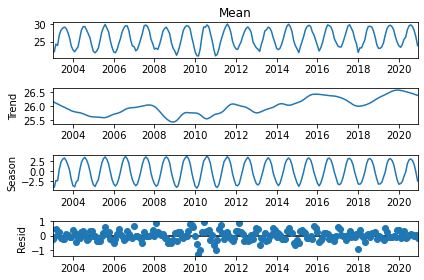

In [11]:
from statsmodels.tsa.seasonal import STL

res = STL(df_simplified['Mean']).fit()
res.plot()

display(res.resid)


# what is next?

* (seagrass) species distribution modeling using (sat) habitat data
   * depth
   * sst
   * wq
   * ...
* ~~predict seagrass residuals w/ other residuals?~~
* 3d plots of time series + grid (2d spatial map w/ 3d as time or something?)
* try loading in seagrass data from GEE

+ tag savannah

## Now for BB3 Data

In [29]:
import pandas

FILEPATH = "../../data/WS19266_BB3.raw"

# read the tab-separated-values file (`.raw` = `.tsv`)
bb3_df = pandas.read_csv(
    FILEPATH, 
    sep='\t',
    on_bad_lines='warn',  # default is 'error'. can also use 'warn' and 'skip'
    names=["date","time","470nm", "470nm_data","532nm", "532nm_data", "650nm", "650nm_data", "mystery_column"],
    skiprows=1,
    # TODO: use more features to better filter
    # mangle_dupe_cols=False,  # not sure if this will be useful
    # dtype={"470nm":np.int64, ...}  # this should fix a lot
    # parsedates = [["date", "time"]]  # this should parse the two columns together as one datetime
)

print("bb3 df before modifications:")
print(bb3_df.head())

# combine date & time columns into one in ISO8601 format
bb3_df['dt'] = bb3_df['date'] + ' ' + bb3_df['time']

# drop cols we don't need
bb3_df_simplified = bb3_df.drop(['date', 'time'], axis=1)

# convert the dt col from string to datetime object
bb3_df_simplified.index = pandas.to_datetime(bb3_df_simplified.dt, errors='coerce')

print("\n=== clean df w/ new 'dt' col:")
print(bb3_df_simplified.head())

# note how pandas automatically started using dt as the index

bb3 df before modifications:
       date      time 470nm 470nm_data 532nm 532nm_data 650nm 650nm_data  \
0  07/29/19  12:06:15   470       2153   532       2043   650       4130   
1  07/29/19  12:06:16   470       2151   532       2034   650       4130   
2  07/29/19  12:06:17   470       2121   532       1994   650       4130   
3  07/29/19  12:06:18   470       2119   532       1992   650       4130   
4  07/29/19  12:06:19   470       2117   532       1991   650       4130   

  mystery_column  
0            536  
1            536  
2            535  
3            535  
4            535  

=== clean df w/ new 'dt' col:
                    470nm 470nm_data 532nm 532nm_data 650nm 650nm_data  \
dt                                                                       
2019-07-29 12:06:15   470       2153   532       2043   650       4130   
2019-07-29 12:06:16   470       2151   532       2034   650       4130   
2019-07-29 12:06:17   470       2121   532       1994   650       4130   

In [39]:
# bb3_df_simplified['2019-07-29 12:06:15']
# bb3_df_simplified['470nm'] != '470'
print("bad values:")
bb3_df_simplified[bb3_df_simplified['470nm'] != '470']



,470nm,470nm_data,532nm,532nm_data,650nm,650nm_data,mystery_column,dt
dt,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07/30/19 00:15:3517
2019-07-30 00:00:00,95,532,111,650,144,516,NaN,07/30/19 00
NaT,93,532,108,650,116,516,NaN,07/30/19 00:16:470
2019-07-30 00:16:29,19,00:16:32,470,93,532,103,650,07/30/19 00:16:29
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
NaT,521,NaN,NaN,NaN,NaN,NaN,NaN,09/29/19 05:066
2019-09-29 05:22:59,650,3789,521,NaN,NaN,NaN,NaN,09/29/19 052259
2019-09-29 05:08:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/29/19 05:08:22


,470nm,470nm_data,532nm,532nm_data,650nm,650nm_data,mystery_column,dt
count,32036,31914,31758,31603,31396,31183,30909,32119
unique,497,2817,516,3058,533,3588,534,32075
top,470,4130,532,4130,650,4130,520,ff/ff/ff ff:ff:ff
freq,31049,2903,30636,2253,30239,6703,2409,15


pre-filtered #rows:32205
multi-filtered #rows:30213


post-obvious wrong filter:


,470nm,470nm_data,532nm,532nm_data,650nm,650nm_data,mystery_column
count,30164,30164,30164,30164,30164,30164,30164
unique,1,2624,1,2863,1,3525,284
top,470,4130,532,4130,650,4130,520
freq,30164,2791,30164,2172,30164,6668,2406




post-drop & convert:


,470nm_data,532nm_data,650nm_data,mystery_column
count,3.016400e+04,3.016400e+04,3.009700e+04,30066.000000
mean,2.247352e+03,1.075002e+03,5.518307e+03,784.589170
std,2.378194e+05,2.464619e+04,3.420344e+05,10557.788235
min,-2.680000e+02,-2.049000e+03,-9.819000e+03,-65.000000
25%,1.240000e+02,1.490000e+02,1.810000e+02,517.000000
50%,2.900000e+02,3.770000e+02,5.260000e+02,521.000000
75%,1.056000e+03,1.109000e+03,3.783000e+03,524.000000
max,4.130413e+07,4.130130e+06,4.130413e+07,534130.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30164 entries, 2019-07-29 12:06:15 to 2019-09-29 17:36:12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   470nm_data      30164 non-null  int64  
 1   532nm_data      30164 non-null  int64  
 2   650nm_data      30097 non-null  float64
 3   mystery_column  30066 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.2 MB


None



post-bounds filter:


,470nm_data,532nm_data,650nm_data,mystery_column
count,21324.000000,21324.000000,21324.000000,21324.000000
mean,327.483915,409.333568,726.437160,519.857578
std,403.769361,484.877515,981.319838,44.310414
min,3.000000,1.000000,1.000000,2.000000
25%,110.000000,129.000000,151.000000,517.000000
50%,160.000000,203.000000,262.000000,520.000000
75%,373.000000,464.000000,752.250000,523.000000
max,4085.000000,4090.000000,4094.000000,4032.000000


done


,470nm_data,532nm_data,650nm_data,mystery_column
dt,,,,
2019-07-29 12:31:30,515,366,2018.0,522.0
2019-07-29 12:31:32,68,48,103.0,522.0
2019-07-29 12:31:33,60,49,67.0,522.0
2019-07-29 12:31:34,65,49,106.0,522.0
2019-07-29 12:31:35,69,48,97.0,522.0
...,...,...,...,...
2019-09-29 05:09:48,1800,360,206.0,519.0
2019-09-29 05:10:12,278,575,311.0,519.0
2019-09-29 05:10:13,929,1525,3847.0,519.0


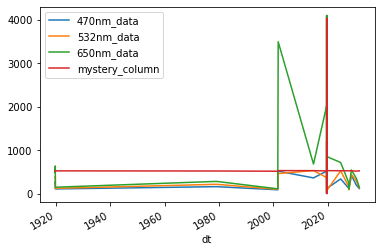

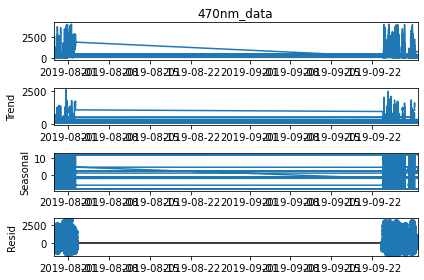

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

display(bb3_df_simplified.describe())

bb3_df_clean = bb3_df_simplified
bb3_df_clean = bb3_df_clean.drop('dt', axis=1)
# == filter out the rows that have obviously bad data
print(f"pre-filtered #rows:{len(bb3_df_clean)}")
# bb3_df_clean = bb3_df_clean[bb3_df_clean['470nm'] == '470']
# print(f"470-filtered #rows:{len(bb3_df_clean)}")
bb3_df_clean = bb3_df_clean[
    (bb3_df_clean['470nm'] == '470') &
    (bb3_df_clean['532nm'] == '532') &
    (bb3_df_clean['650nm'] == '650')
]
print(f"multi-filtered #rows:{len(bb3_df_clean)}")

bb3_df_clean = bb3_df_clean.dropna()

print('\n\npost-obvious wrong filter:')
display(bb3_df_clean.describe())

# === convert to numeric
for col in ['470nm_data', '532nm_data', '650nm_data', 'mystery_column']:
    bb3_df_clean[col] = pandas.to_numeric(bb3_df_clean[col], errors='coerce')

bb3_df_clean = bb3_df_clean.drop(['470nm', '532nm', '650nm'], axis=1)
    
print('\n\npost-drop & convert:')
display(bb3_df_clean.describe(include='all'))
display(bb3_df_clean.info())

# === filter out data outside known bounds of 12-bit sensors
SENSOR_MIN = 0
SENSOR_MAX = 4095
bb3_df_clean = bb3_df_clean[
    (bb3_df_clean['470nm_data'] > SENSOR_MIN) &
    (bb3_df_clean['470nm_data'] < SENSOR_MAX) &
    (bb3_df_clean['532nm_data'] > SENSOR_MIN) &
    (bb3_df_clean['532nm_data'] < SENSOR_MAX) &
    (bb3_df_clean['650nm_data'] > SENSOR_MIN) &
    (bb3_df_clean['650nm_data'] < SENSOR_MAX) &
    (bb3_df_clean['mystery_column'] > SENSOR_MIN) &
    (bb3_df_clean['mystery_column'] < SENSOR_MAX)

]
print('\n\npost-bounds filter:')
display(bb3_df_clean.describe(include='all'))



bb3_df_clean.plot()



# In seasonal_decompose we have to set the model. 
# We can either set the model to be Additive or Multiplicative. 
# A rule of thumb for selecting the right model is to see in our plot if the trend and seasonal variation are relatively constant over time.
# IE: linear. 
# If yes, then we will select the Additive model.
# Otherwise (the trend and seasonal variation increase or decrease over time) use the Multiplicative model.
result = seasonal_decompose(bb3_df_clean['470nm_data'], model='additive', period=12)
result.plot()

print('done')

# Trend    : decreasing, constant, or increasing over time.
# Seasonal : periodic signal
# residuals: variability in the data that cannot be explained by the seasonal+trend model

display(bb3_df_clean)